# ML-Pipeline


[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 0. Dependencies

In [14]:
# setup dependencies
import sys
import sklearn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Evaluation Function


def evaluate_model(y_true, y_pred, y_proba):
    return {
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

# Plotting Function


def plot_scores(scores_dict, title):
    metrics = list(scores_dict.keys())
    values = list(scores_dict.values())
    plt.bar(metrics, values)
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()


# Load datasets
datasets = {
    'Dataset1': pd.read_csv('dataset1.csv'),
    'Dataset2': pd.read_csv('dataset2.csv'),
    'Dataset3': pd.read_csv('dataset3.csv'),
    'Dataset4': pd.read_csv('dataset4.csv')
}

results = {}

for dataset_name, data in datasets.items():
    # Please adjust 'target' to match your dataset
    X = data.drop('target', axis=1)
    y = data['target']

    # Split data for holdout validation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Preprocessing
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize models
    classifiers = {
        'kNN': GridSearchCV(KNeighborsClassifier(),
                            {'n_neighbors': [3, 5, 7, 9, 11],
                             'weights': ['uniform', 'distance'],
                             'metric': ['euclidean', 'manhattan']},
                            cv=5, scoring='f1', n_jobs=-1),

        'RandomForest': GridSearchCV(RandomForestClassifier(random_state=42),
                                     {'n_estimators': [50, 100, 150, 200],
                                      'max_depth': [None, 10, 20, 30],
                                      'min_samples_split': [2, 5, 10],
                                      'min_samples_leaf': [1, 2, 4]},
                                     cv=5, scoring='f1', n_jobs=-1),

        'SVM': GridSearchCV(SVC(probability=True, random_state=42),
                            {'C': [0.1, 1, 10, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'rbf']},
                            cv=5, scoring='f1', n_jobs=-1)
    }

    results[dataset_name] = {'Holdout': {}, 'CrossVal': {}}

    for clf_name, model in classifiers.items():
        # Step 1: Holdout validation
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        holdout_scores = evaluate_model(y_test, y_pred, y_proba)
        results[dataset_name]['Holdout'][clf_name] = holdout_scores

        # Plot Holdout scores
        plot_scores(holdout_scores, f"{
                    dataset_name} - {clf_name} Holdout Performance")

        # Step 2: Cross-validation
        cv_score_f1 = cross_val_score(
            model, X, y, cv=5, scoring='f1', n_jobs=-1)
        cv_score_auc = cross_val_score(
            model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

        crossval_scores = {'F1 Score': np.mean(
            cv_score_f1), 'ROC AUC': np.mean(cv_score_auc)}
        results[dataset_name]['CrossVal'][clf_name] = crossval_scores

        # Plot Cross-Validation scores
        plot_scores(crossval_scores, f"{
                    dataset_name} - {clf_name} Cross-Validation Performance")

# Comparison Output
for dataset_name, validation_methods in results.items():
    print(f"Results for {dataset_name}:")
    for method, classifiers_scores in validation_methods.items():
        print(f"{method} Validation:")
        for clf_name, scores in classifiers_scores.items():
            print(f"{clf_name} Scores: {scores}")


## 1. Read & Introduce Data

In [2]:
read_df = pd.read_csv('data/congressional-voting/CongressionalVotingID.shuf.lrn.csv',sep=',')
read_df.head()

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,democrat,y,n,y,n,y,y,y,n,y,y,n,n,y,y,n,unknown
1,86,democrat,n,n,y,n,y,y,n,n,n,y,y,y,y,y,n,y
2,264,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
3,258,republican,n,n,n,y,y,n,n,n,n,n,n,y,n,y,unknown,y
4,381,democrat,y,y,y,n,n,y,unknown,y,y,n,y,n,y,n,y,y


In [5]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      218 non-null    int64 
 1   class                                   218 non-null    object
 2   handicapped-infants                     218 non-null    object
 3   water-project-cost-sharing              218 non-null    object
 4   adoption-of-the-budget-resolution       218 non-null    object
 5   physician-fee-freeze                    218 non-null    object
 6   el-salvador-aid                         218 non-null    object
 7   religious-groups-in-schools             218 non-null    object
 8   anti-satellite-test-ban                 218 non-null    object
 9   aid-to-nicaraguan-contras               218 non-null    object
 10  mx-missile                              218 non-null    object
 11  immigr

In [6]:
read_df.describe()

,ID
count,218.000000
mean,209.279817
std,125.726093
min,6.000000
25%,102.250000
50%,209.500000
75%,315.500000
max,433.000000


### 1.1 Feature Description
list of features and their meaning

## 2. Analyse Data

In [7]:
analysis_df = read_df

### 2.1 Histograms

### 2.2 Boxplots

## 3. Train Test Split

In [3]:
test_train_df = read_df.copy()
test_train_df = test_train_df.drop('ID',axis=1)

In [4]:
test_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   class                                   218 non-null    object
 1   handicapped-infants                     218 non-null    object
 2   water-project-cost-sharing              218 non-null    object
 3   adoption-of-the-budget-resolution       218 non-null    object
 4   physician-fee-freeze                    218 non-null    object
 5   el-salvador-aid                         218 non-null    object
 6   religious-groups-in-schools             218 non-null    object
 7   anti-satellite-test-ban                 218 non-null    object
 8   aid-to-nicaraguan-contras               218 non-null    object
 9   mx-missile                              218 non-null    object
 10  immigration                             218 non-null    object
 11  synfue

In [5]:
target_prediction = 'class'

In [6]:
from sklearn.model_selection import train_test_split
test_size = 0.2
y = test_train_df.pop(target_prediction)
# todo: compare holdout to cross validtion
#   - Pay attention to your splits and settings
#       Are there differences? Why? In which metrics? What could have caused it?
#   - Compare/document changes in runtime behaviour with the changing eg. dataset size
X_train, X_test, y_train, y_test = train_test_split(test_train_df, y, test_size=test_size, random_state=42)
(len(X_train), len(X_test))

(174, 44)

## 4. Correlations

## 5. Feature Combination

## 6. Preproccessing & Feature Scaling

In [7]:
preprocessing_df = X_train.copy()

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

topic_columns = ["handicapped-infants", "water-project-cost-sharing", "adoption-of-the-budget-resolution", "physician-fee-freeze", "el-salvador-aid", "religious-groups-in-schools", "anti-satellite-test-ban",
                 "aid-to-nicaraguan-contras", "mx-missile", "immigration", "synfuels-crporation-cutback", "education-spending", "superfund-right-to-sue", "crime", "duty-free-exports", "export-administration-act-south-africa"]

topic_transformer = ColumnTransformer(
    transformers=[
        ('topic_encoder', OneHotEncoder(handle_unknown='ignore'), topic_columns)
    ],
    remainder='passthrough'
)
preprocessor = Pipeline(steps=[
    ('topic_transformer', topic_transformer),
])

## 7. Model Selection

In [ ]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# todo: implement proper preprocessing for each dataset (missing values, outliers, scaling, encoding, etc.)
pipeline = preprocessor
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# todo: pick only 3 classifiers, but make sure that 
#   you choose from at least two different "types"/"paradigms"
#   eg do not choose 3 tree-based classifiers, or 3 NN based classifiers, or 3 ensembles, ...
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "kNN": KNeighborsClassifier()
}

param_distributions = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    },
    "kNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }
}

results = {}
for name, clf in classifiers.items():
    # Perform random search
    random_search = RandomizedSearchCV(
        clf,
        param_distributions=param_distributions[name],
        n_iter=10,
        cv=5,
        random_state=42
    )
    random_search.fit(X_train_scaled, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate accuracy and perform cross-validation
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)

    results[name] = {
        "accuracy": accuracy,
        "cv_mean": np.mean(cv_scores),
        "cv_std": np.std(cv_scores),
        "best_params": random_search.best_params_
    }

# Print results
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    print(f"Cross-validation: {result['cv_mean']:.4f} (+/- {result['cv_std']*2:.4f})")

# todo: Can you identify any patterns/trends?
#   - Which methods work well and which did not, is there e.g. one method
#       outperforming the others on all datasets?
#   - How do the results change when preprocessing strategies change? How sensitive
#       is an algorithm to parameter settings?
#   - Are there differences across the datasets? Design your experiments so that you
#       can investigate the influence of single parameters.
# Compare accuracies
best_classifier = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest Classifier: {best_classifier} with accuracy {
      results[best_classifier]['accuracy']:.4f}")

# todo: Evaluate and analyse the performance (primarily effectiveness, 
#   but also provide basic details on efficiency):
#   - Choose suitable, multiple performance measures
#   - Make valid comparisons (among the classifiers, across your datasets, parameters,
#       preprocessing effects...)
#   - (How) can you improve the results?


Random Forest:
Test Accuracy: 0.9545
Cross-validation: 0.9598 (+/- 0.0581)

SVM:
Test Accuracy: 0.9545
Cross-validation: 0.9654 (+/- 0.0671)

kNN:
Test Accuracy: 0.9773
Cross-validation: 0.9190 (+/- 0.1251)

Best Classifier: kNN with accuracy 0.9773


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_we

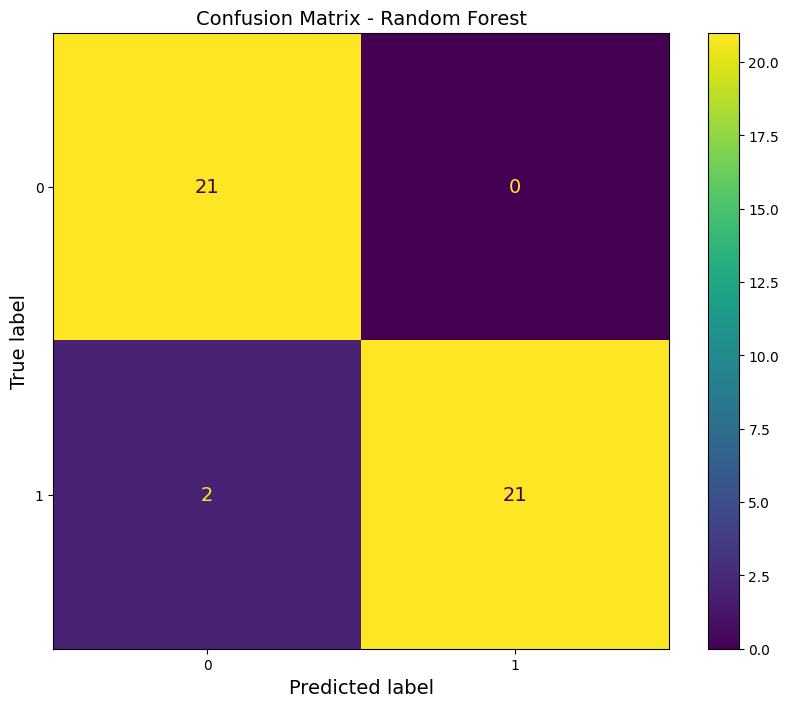

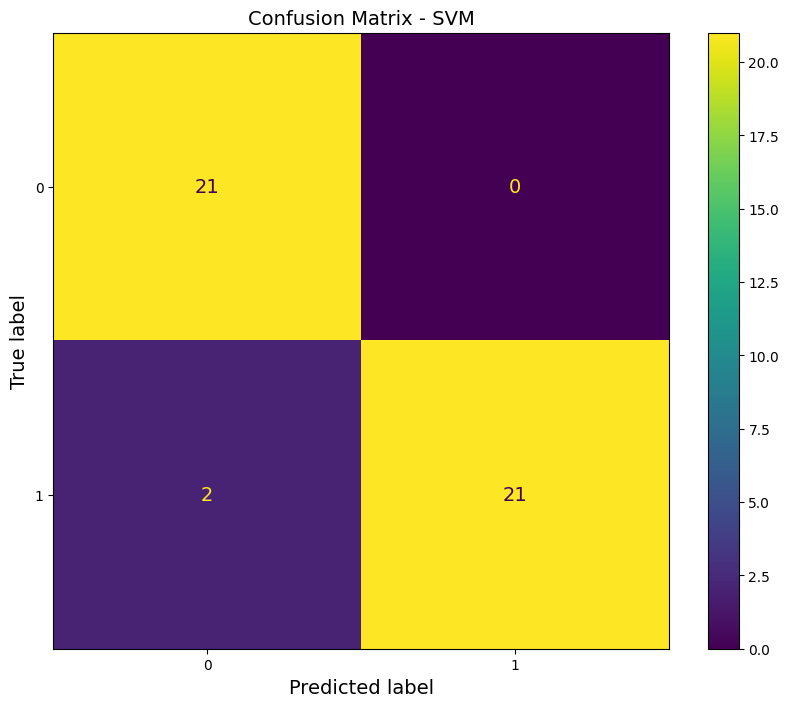

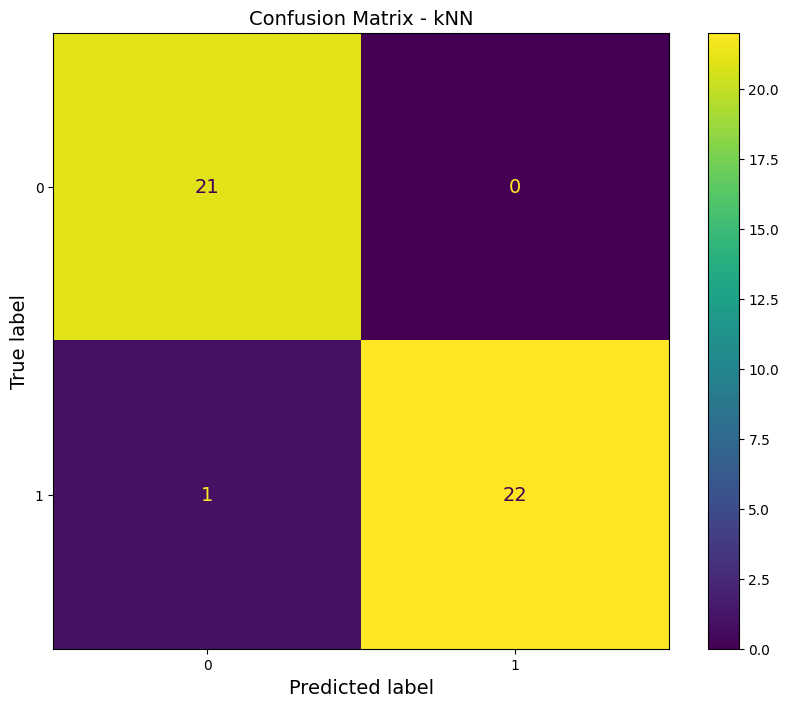


Random Forest:
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Test Accuracy: 0.9545
Precision: 0.9585
Recall: 0.9545
F1-score: 0.9545
ROC AUC: 1.0000

SVM:
Best Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 10}
Test Accuracy: 0.9545
Precision: 0.9585
Recall: 0.9545
F1-score: 0.9545
ROC AUC: 1.0000

kNN:
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 3}
Test Accuracy: 0.9773
Precision: 0.9783
Recall: 0.9773
F1-score: 0.9773
ROC AUC: 0.9783

Best Classifier: kNN with accuracy 0.9773


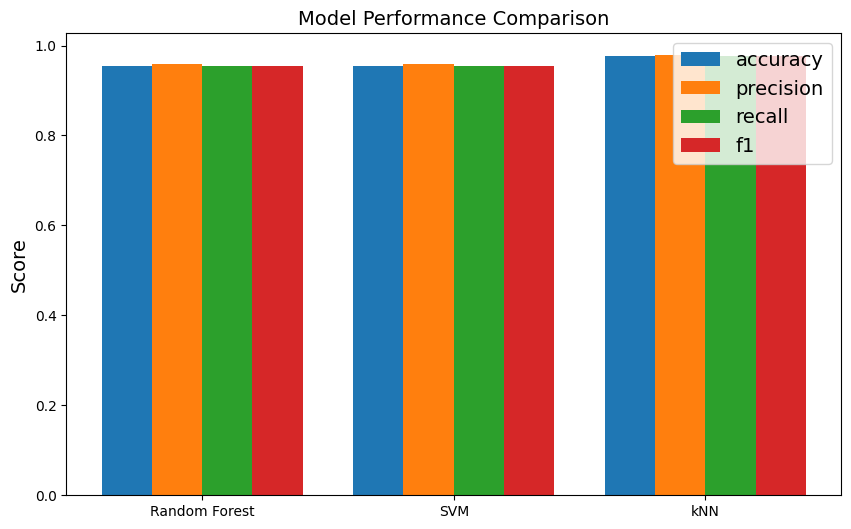

In [12]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)
    plt.title(title)
    plt.show()

def evaluate_model(model: Any, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    y_pred = model.predict(X_test)

    # y_pred_labels = LABEL_ENCODER_GLOBAL.inverse_transform(y_pred)
    # y_test_labels = LABEL_ENCODER_GLOBAL.inverse_transform(y_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    except AttributeError:
        roc_auc = None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_test': y_test
    }

def plot_results(results: Dict[str, Dict[str, float]]):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(results))
    width = 0.2
    for i, metric in enumerate(metrics):
        values = [results[clf][metric] for clf in results]
        ax.bar(x + i*width, values, width, label=metric)
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(results.keys())
    ax.legend(loc='best')
    plt.show()

pipeline = preprocessor
# Assume X_train, X_test, y_train, y_test are already defined
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
# global LABEL_ENCODER_GLOBAL
# LABEL_ENCODER_GLOBAL = label_encoder

classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "kNN": KNeighborsClassifier()
}

param_distributions = {
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto", 0.1, 1]
    },
    "kNN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }
}

results = {}
for name, clf in classifiers.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        clf,
        param_distributions=param_distributions[name],
        n_iter=20,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train_scaled, y_train)
    best_model = random_search.best_estimator_
    results[name] = evaluate_model(best_model, X_test_scaled, y_test)
    results[name]['best_params'] = random_search.best_params_

    y_pred = results[name]['y_pred']
    y_test_plot = results[name]['y_test']
    class_names = label_encoder.classes_
    plot_confusion_matrix(y_test_plot, y_pred, class_names, f"Confusion Matrix - {name}")

for name, result in results.items():
    print(f"\n{name}:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-score: {result['f1']:.4f}")
    if result['roc_auc']:
        print(f"ROC AUC: {result['roc_auc']:.4f}")

best_classifier = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest Classifier: {best_classifier} with accuracy {results[best_classifier]['accuracy']:.4f}")

plot_results(results)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


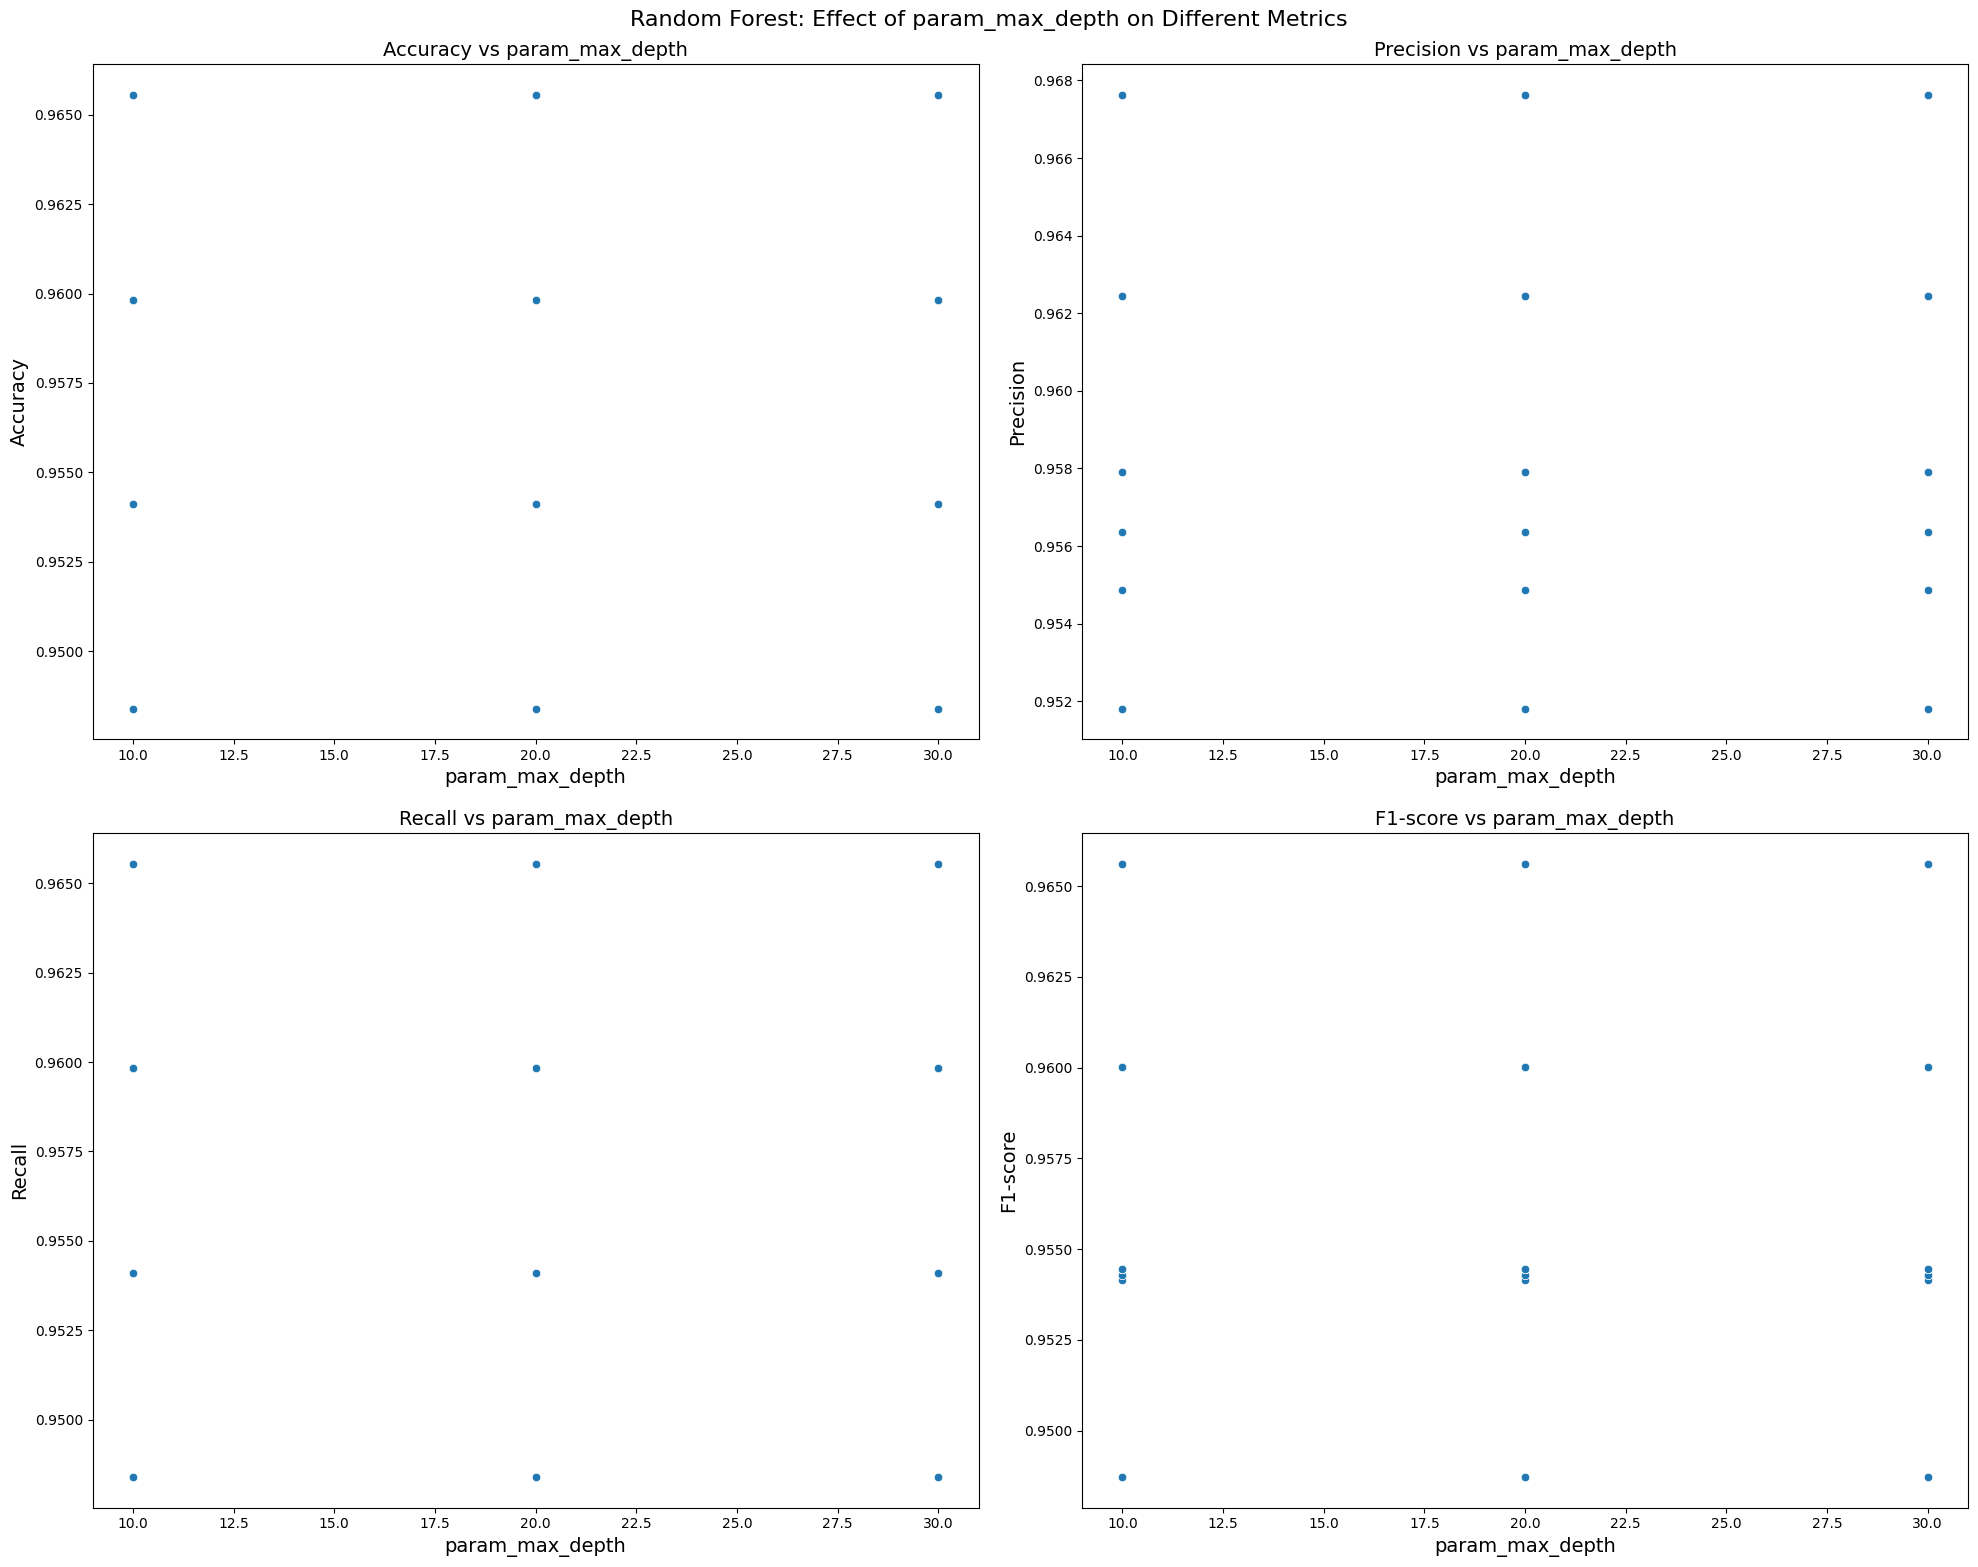

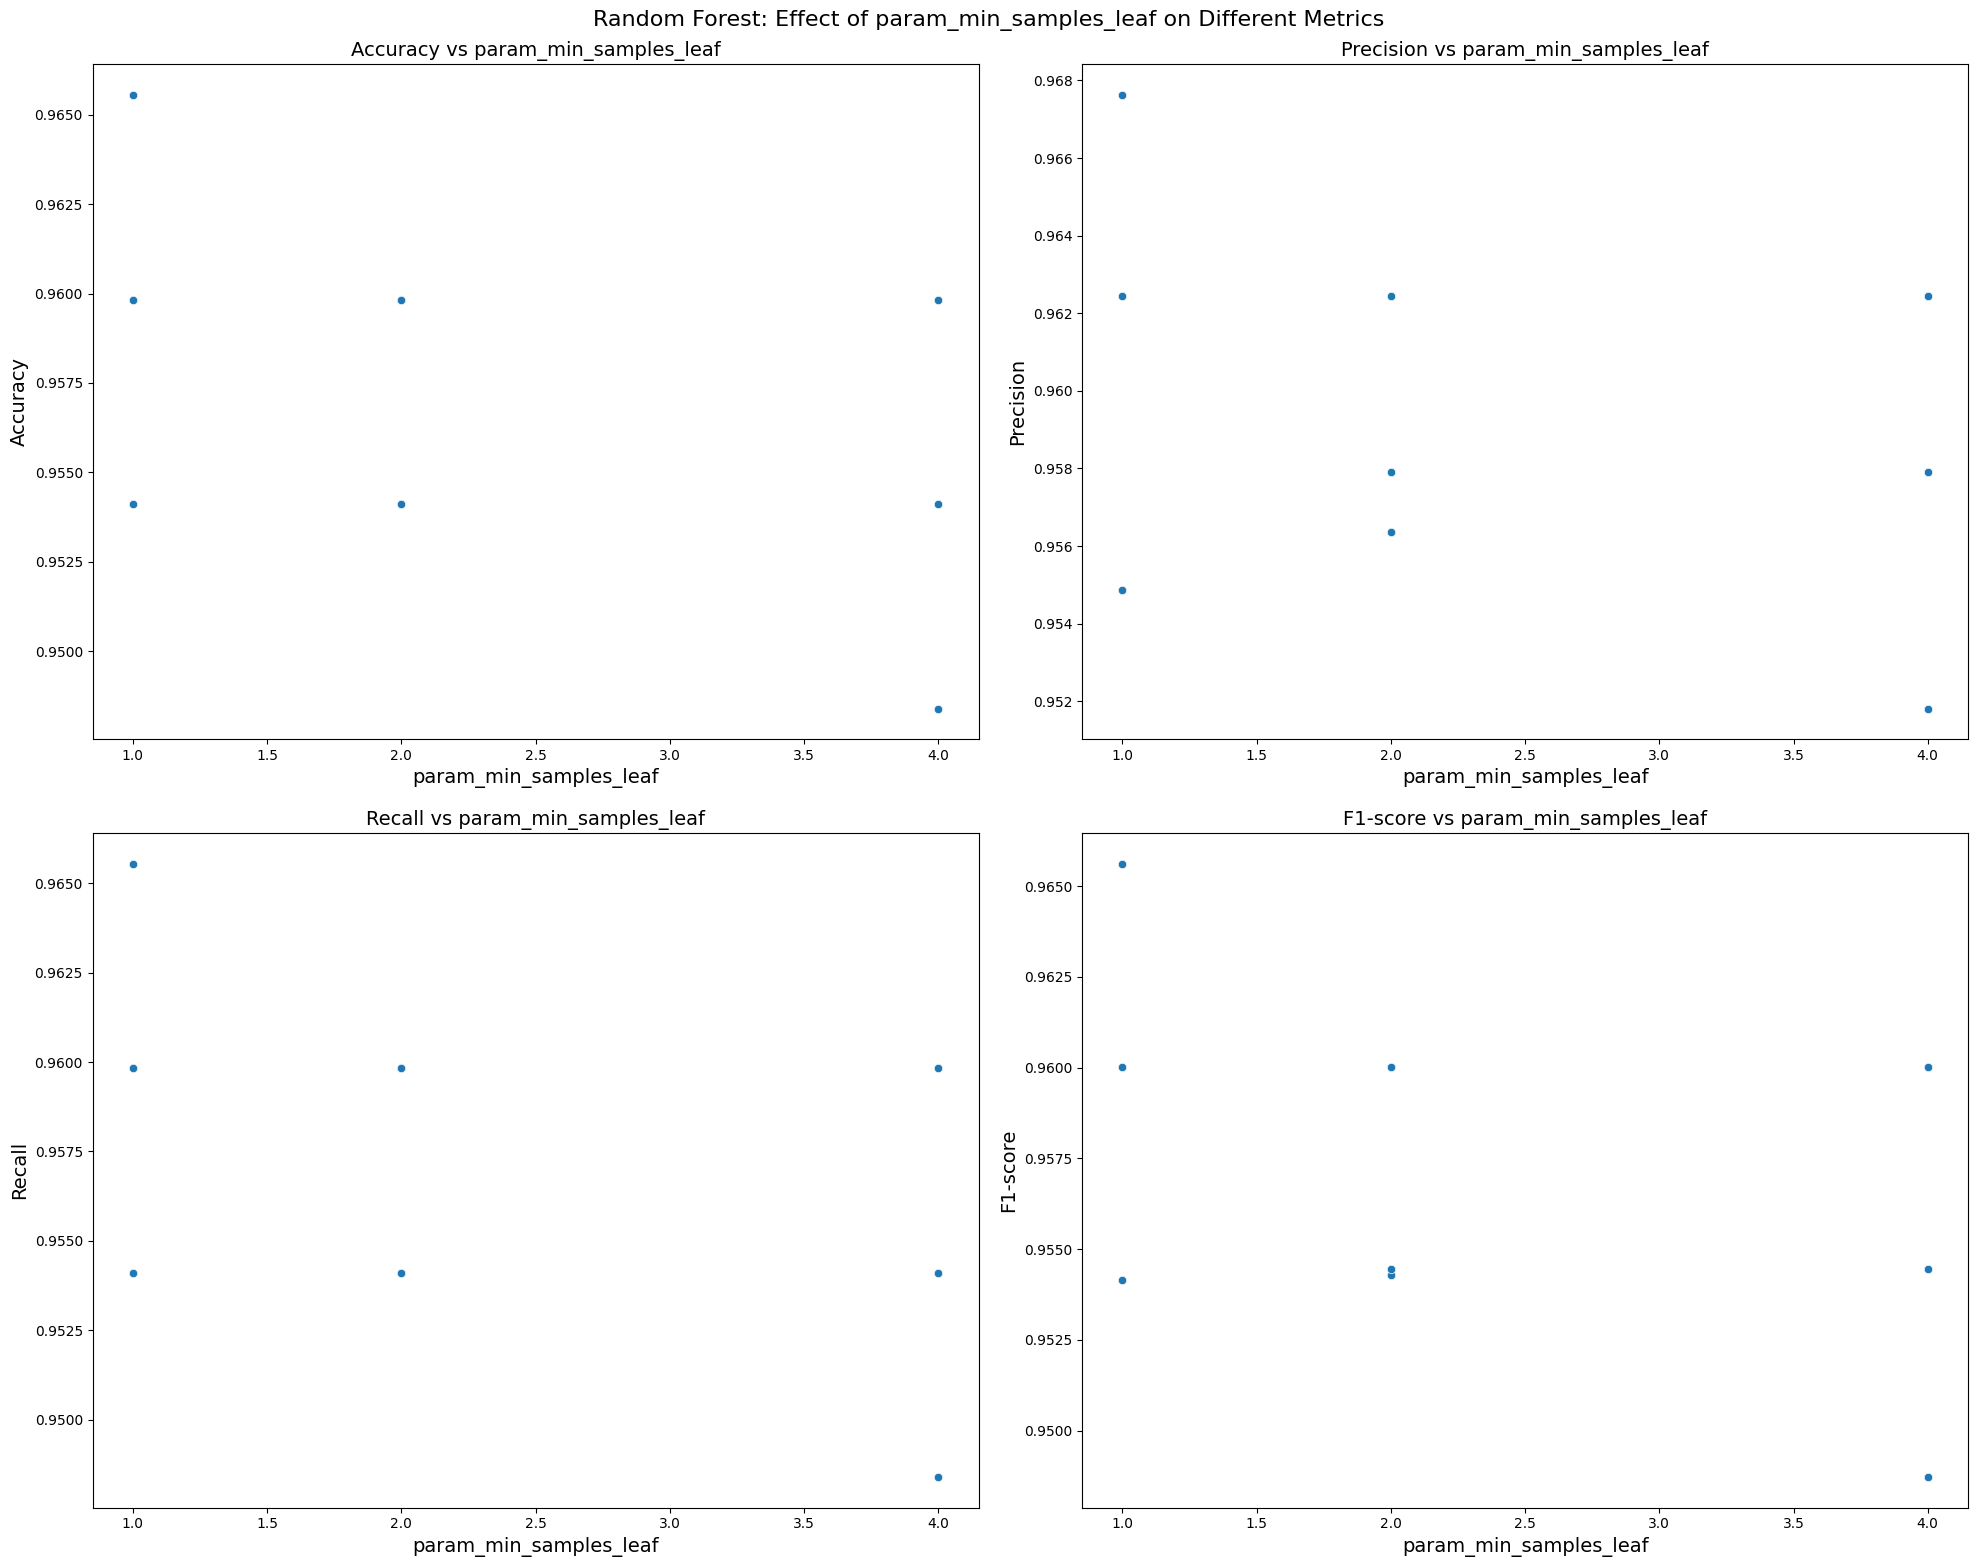

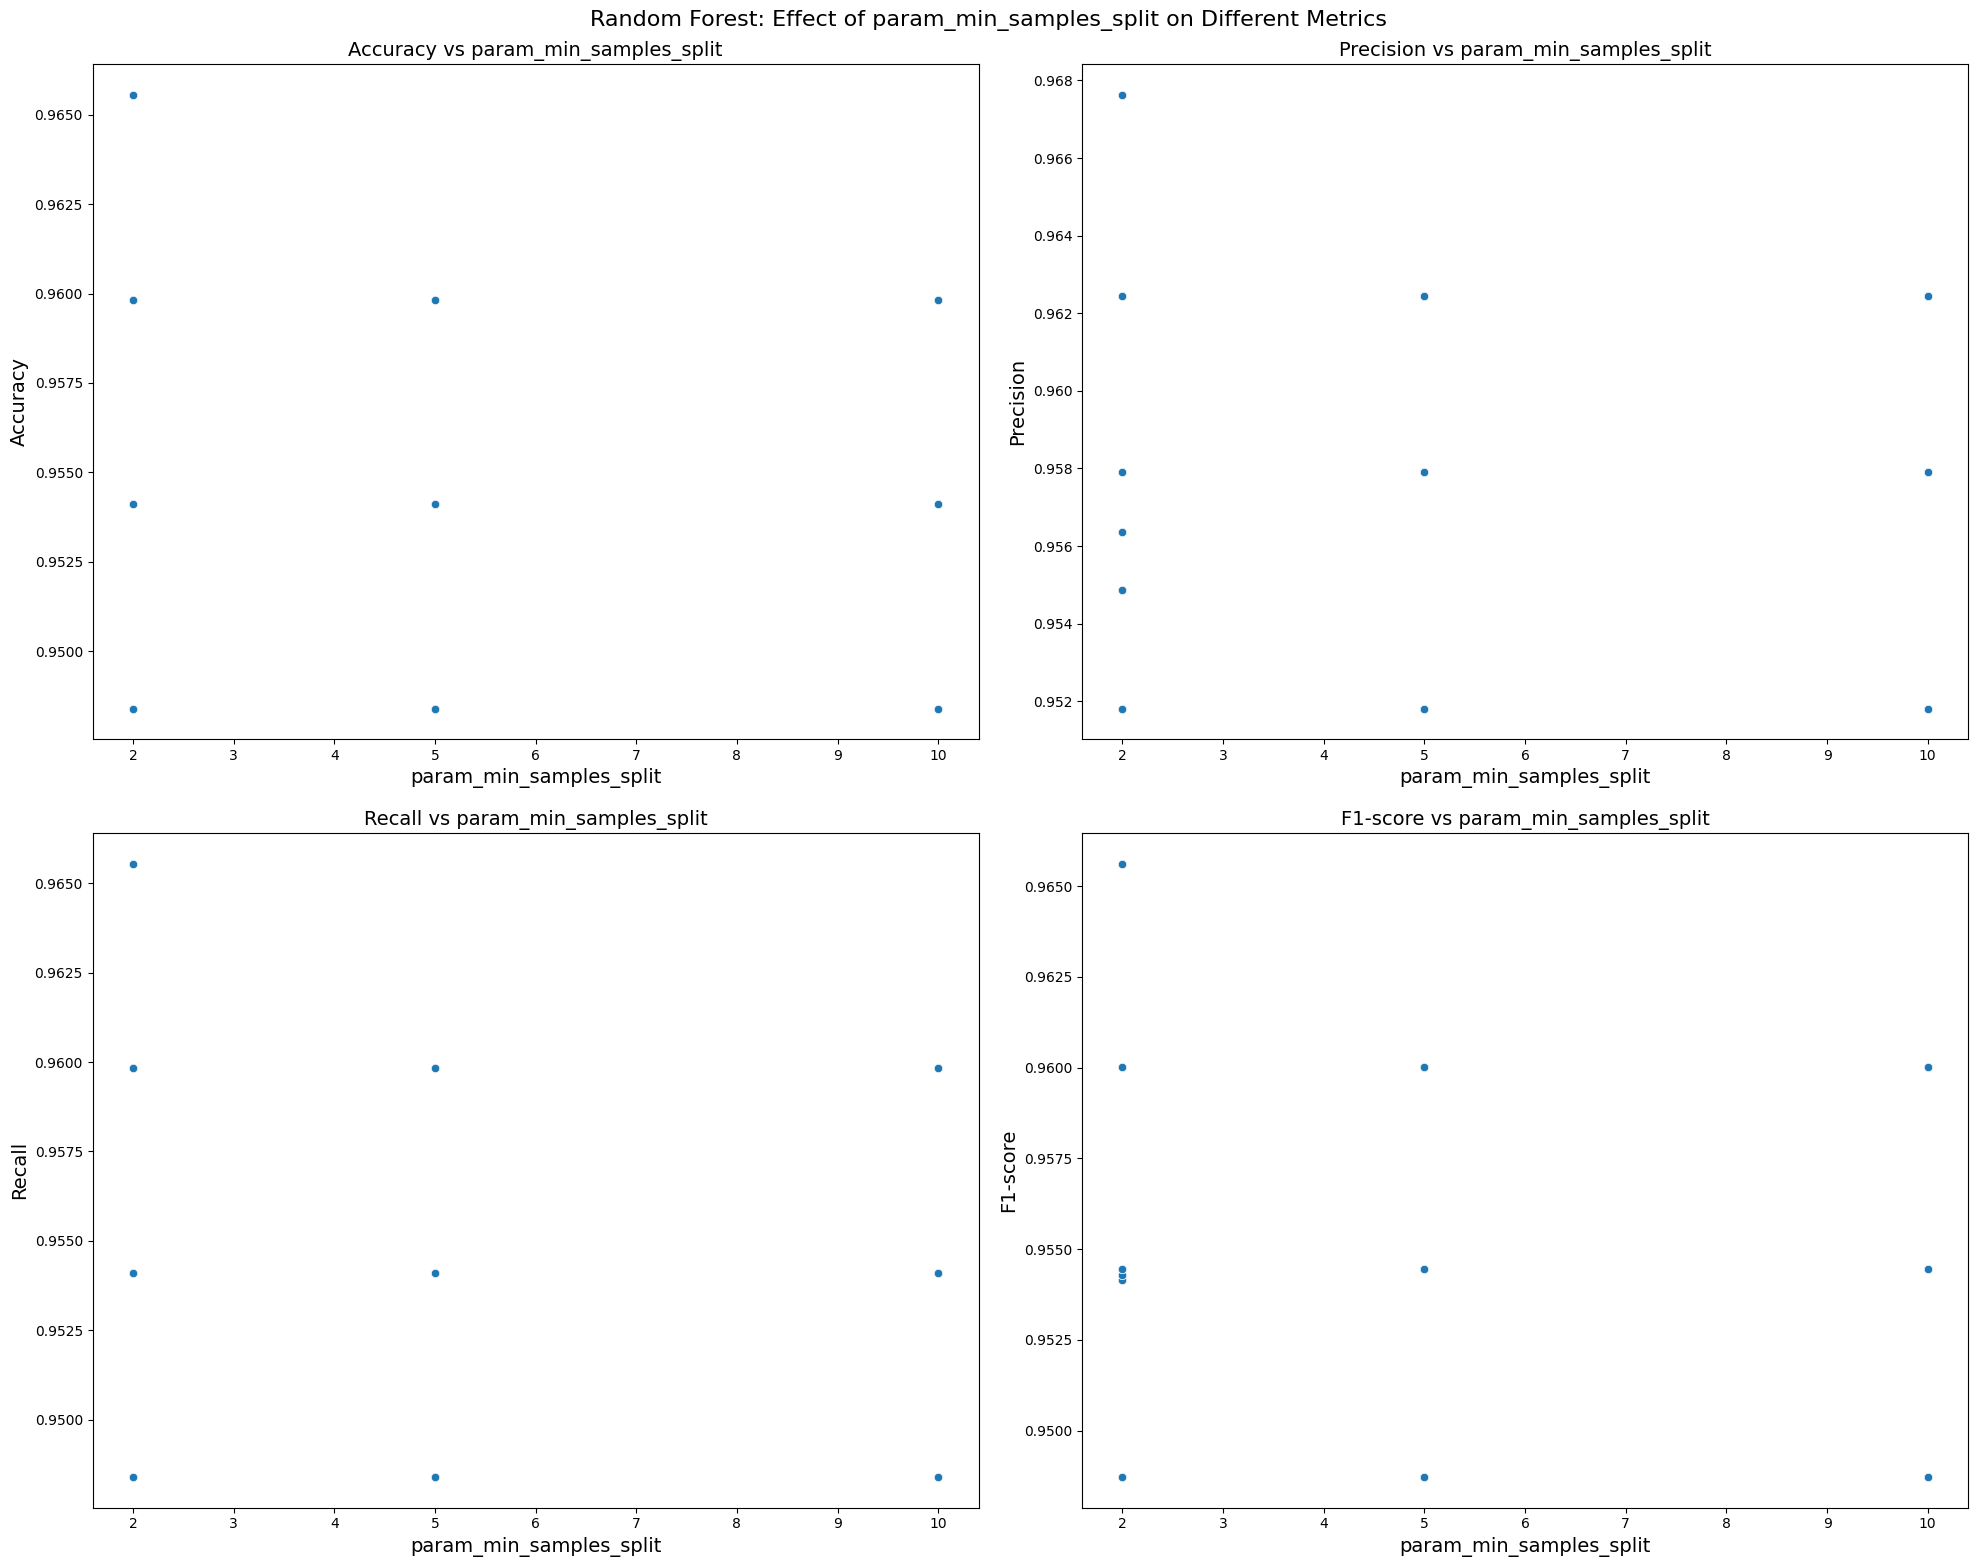

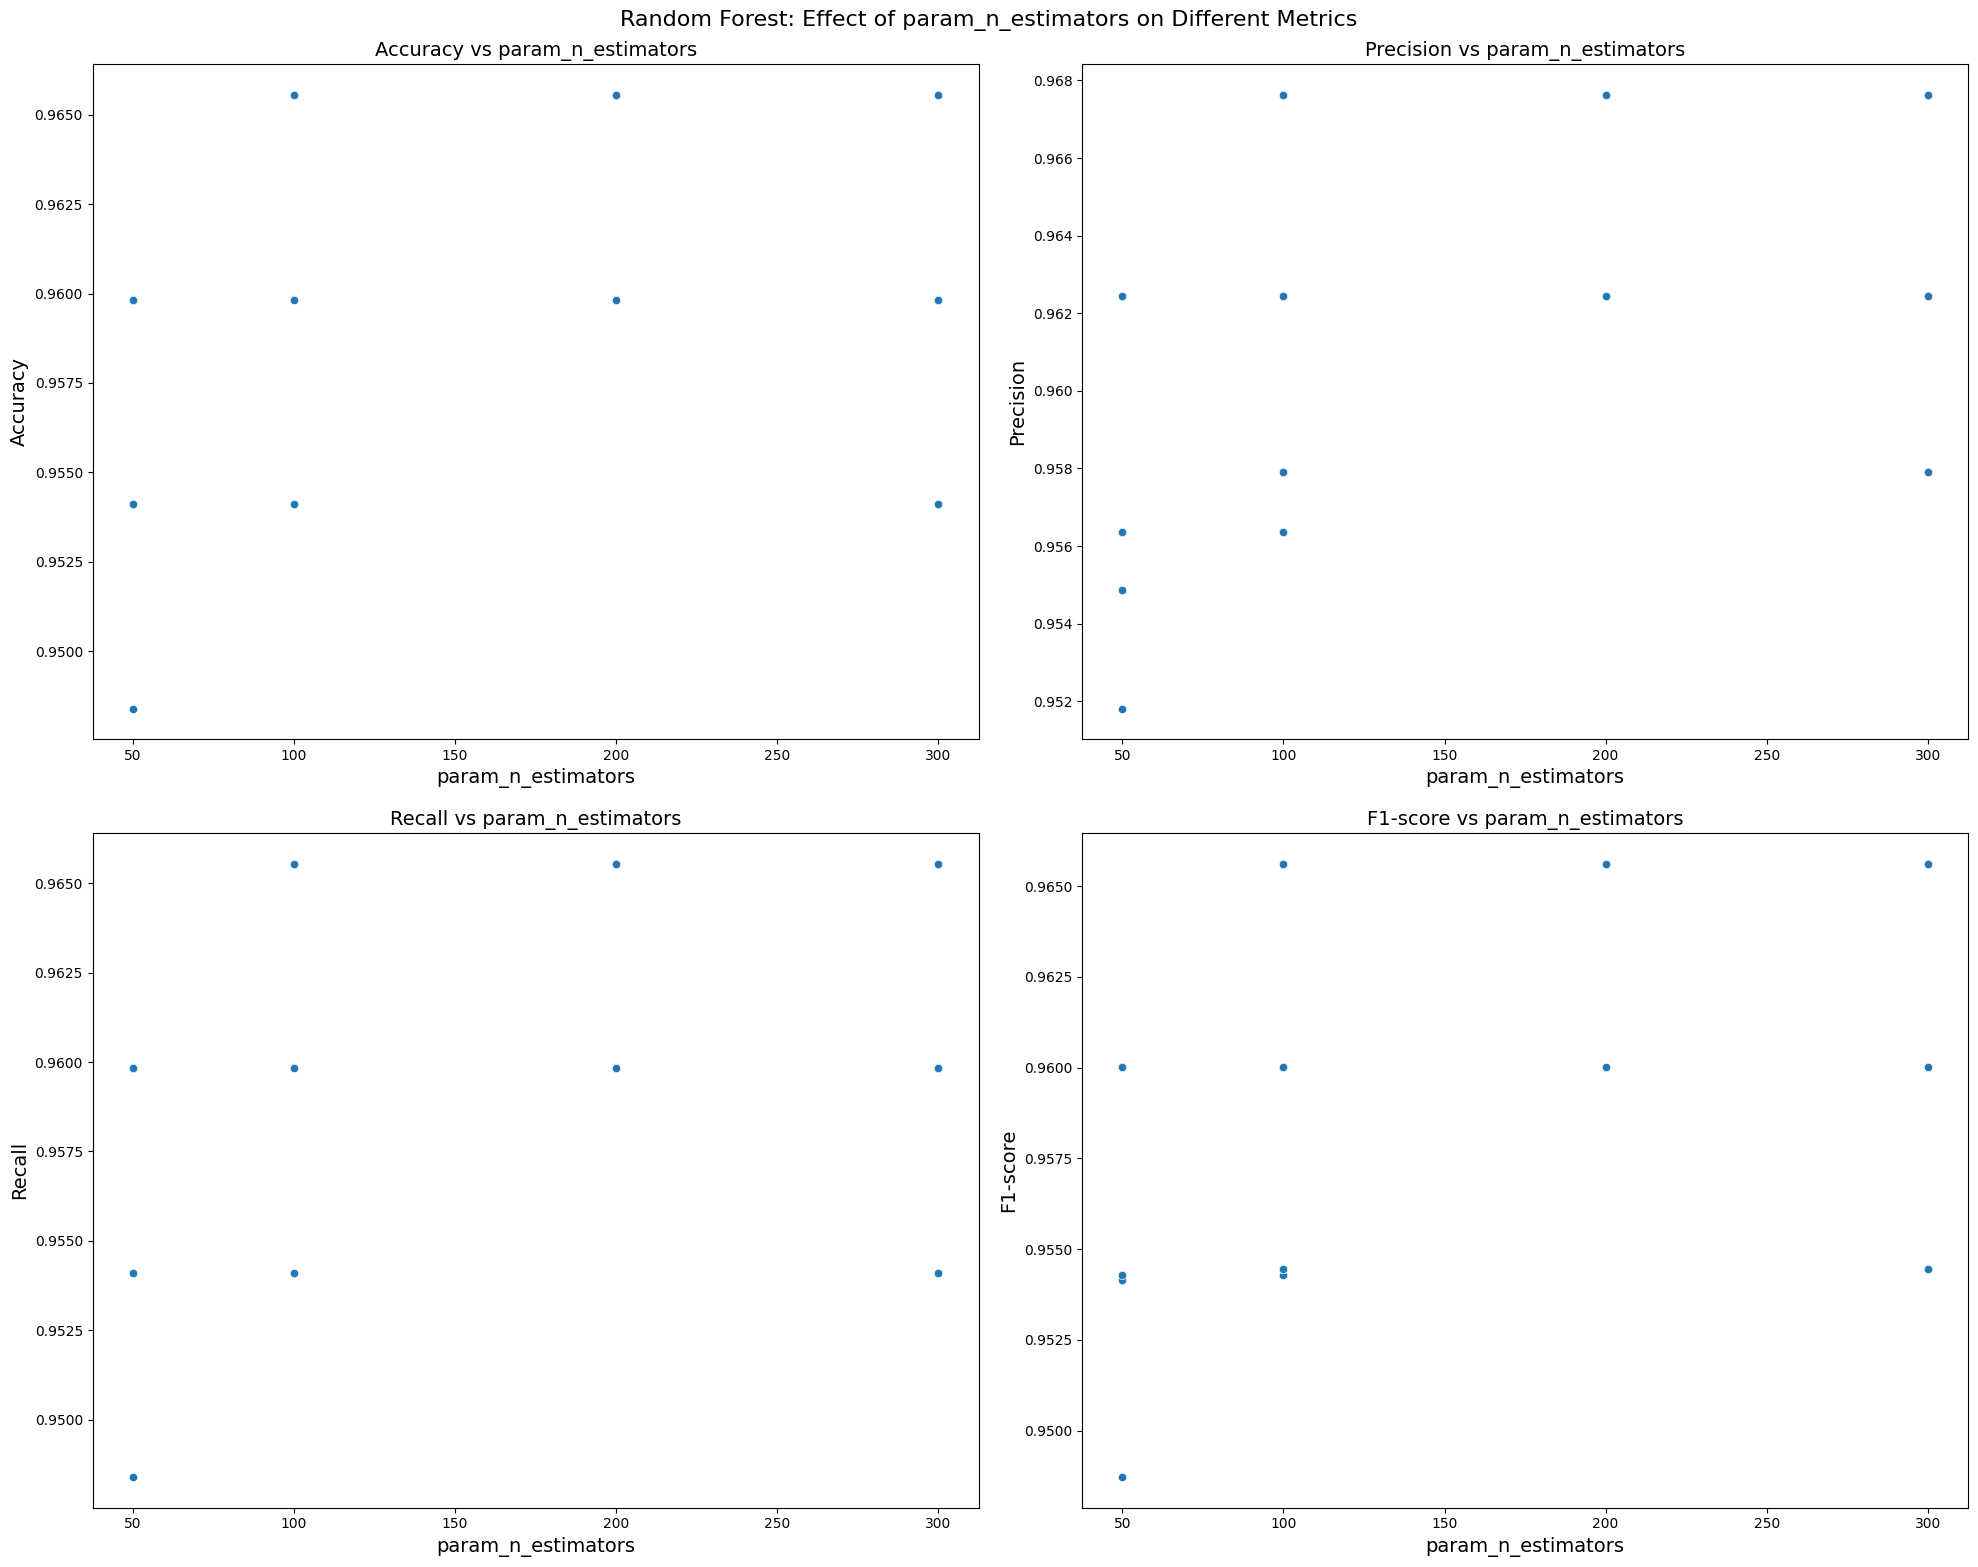

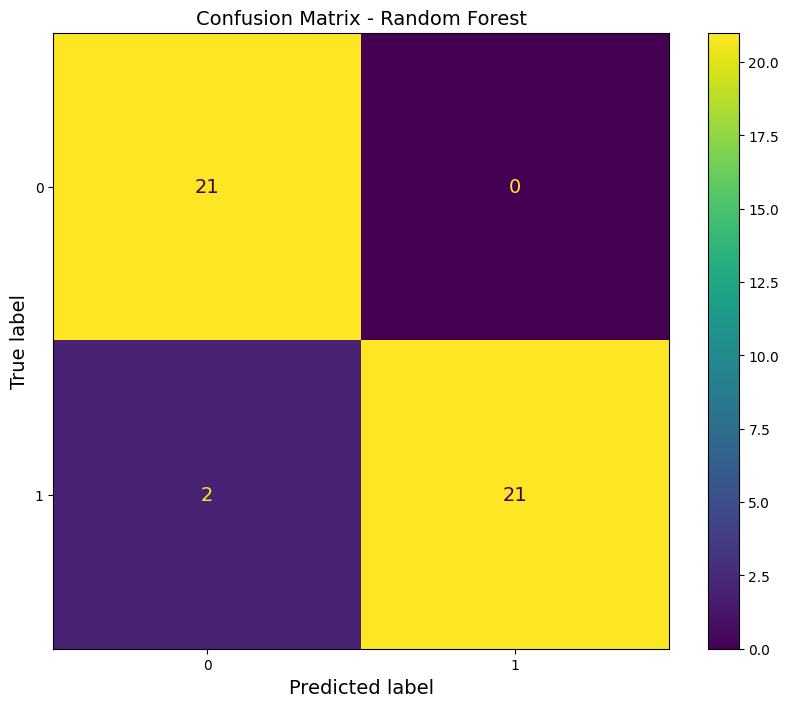

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

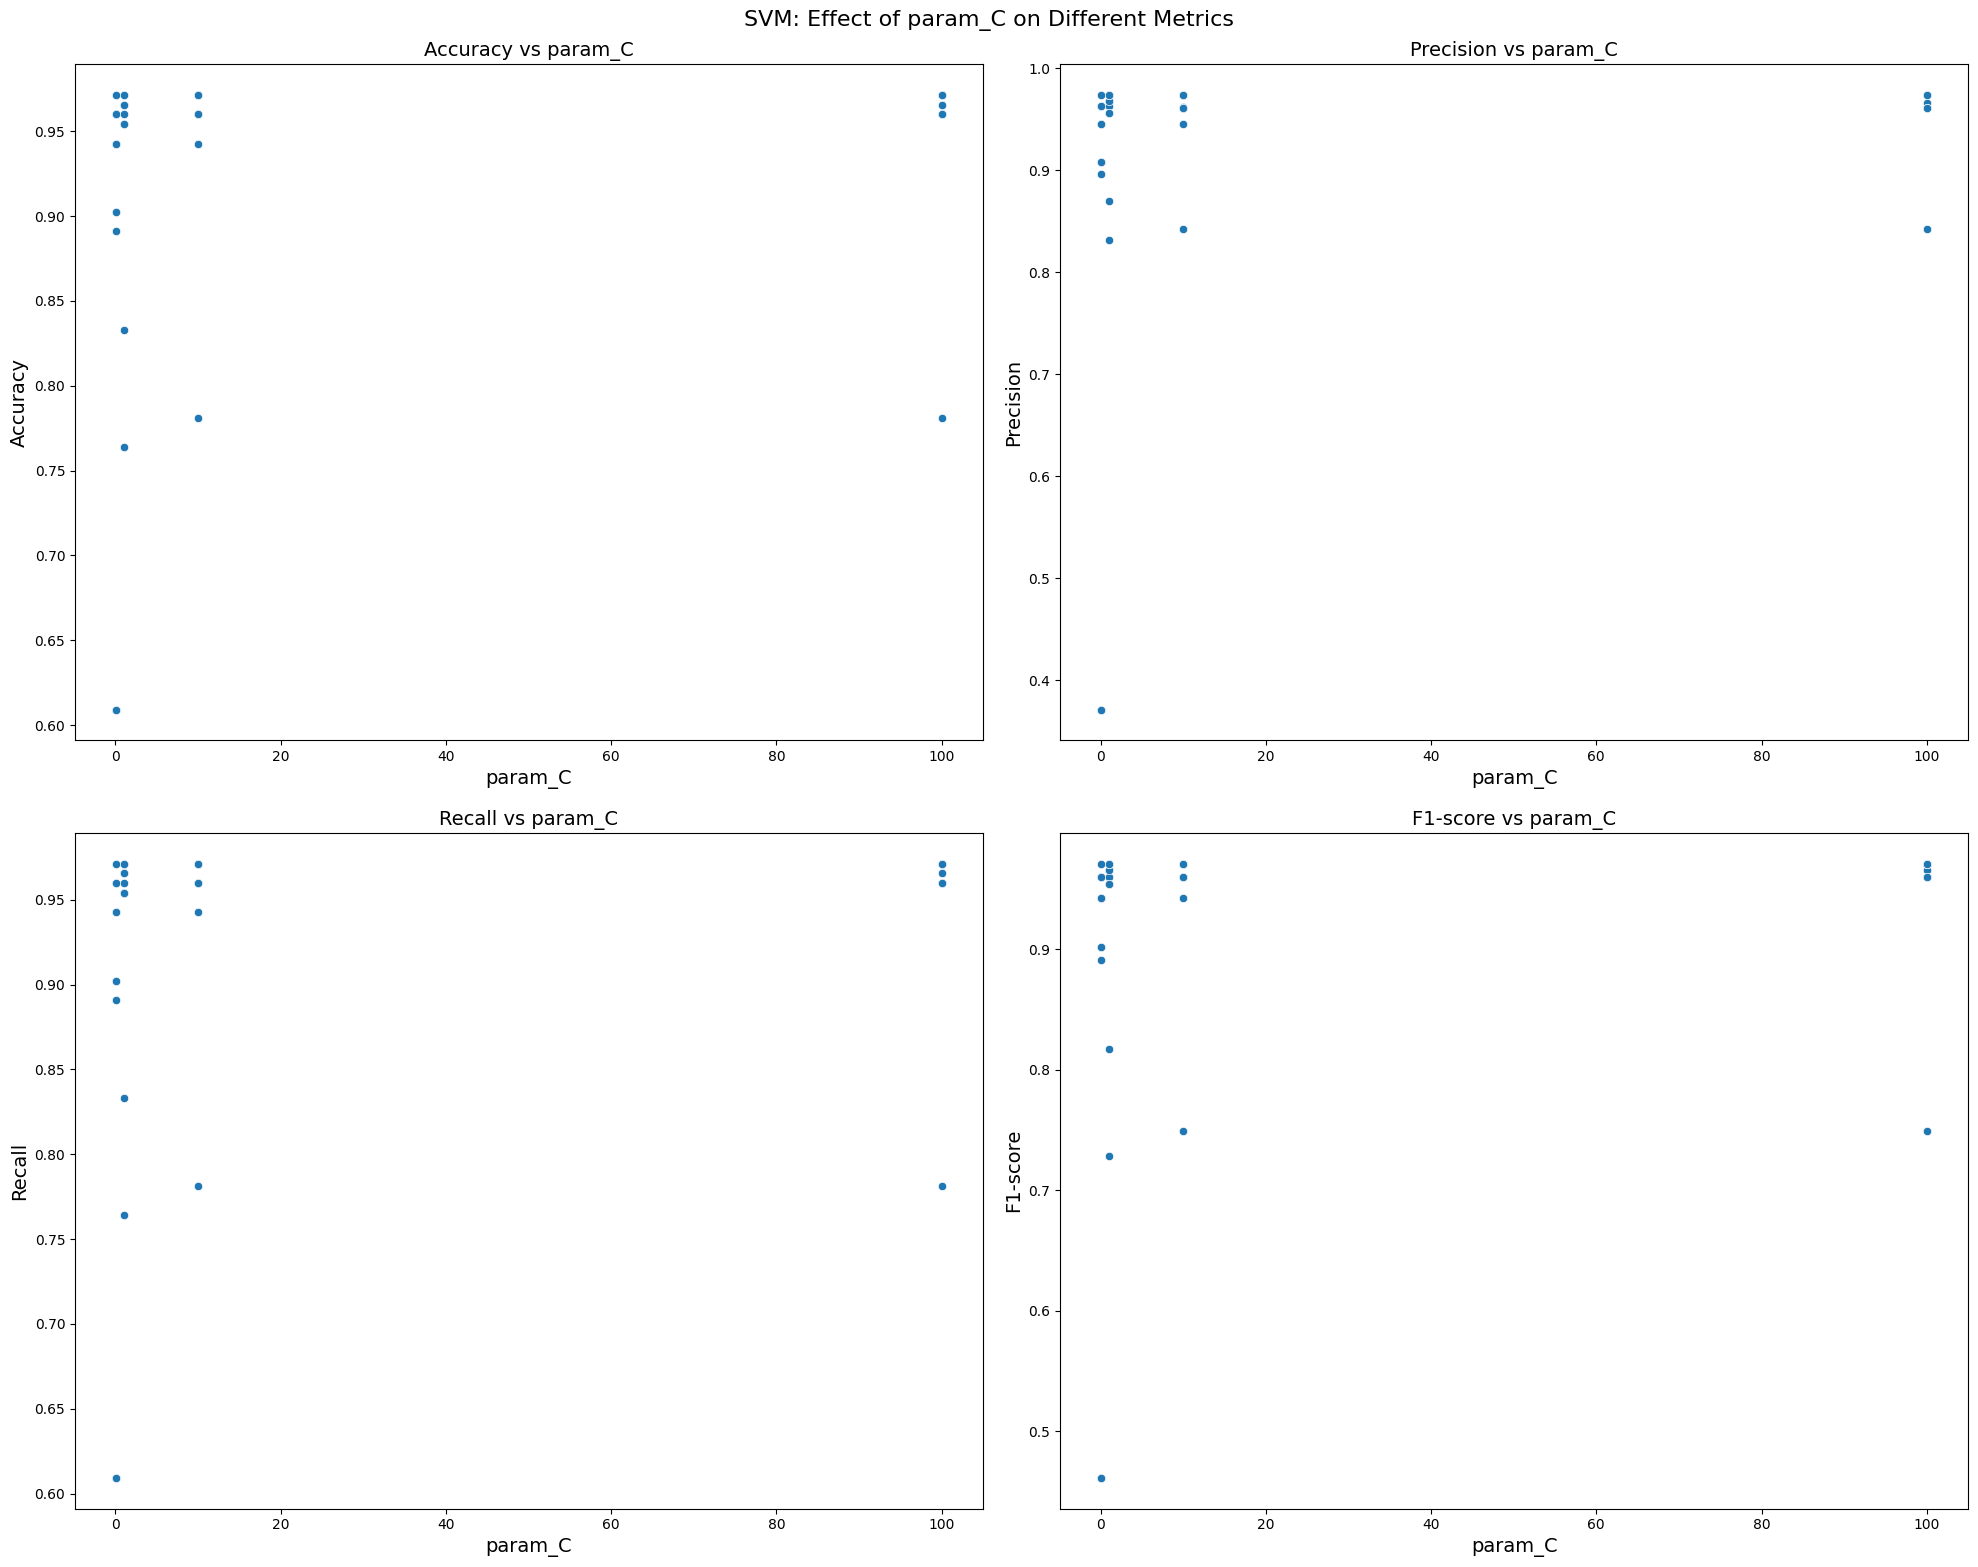

TypeError: 'value' must be an instance of str or bytes, not a float

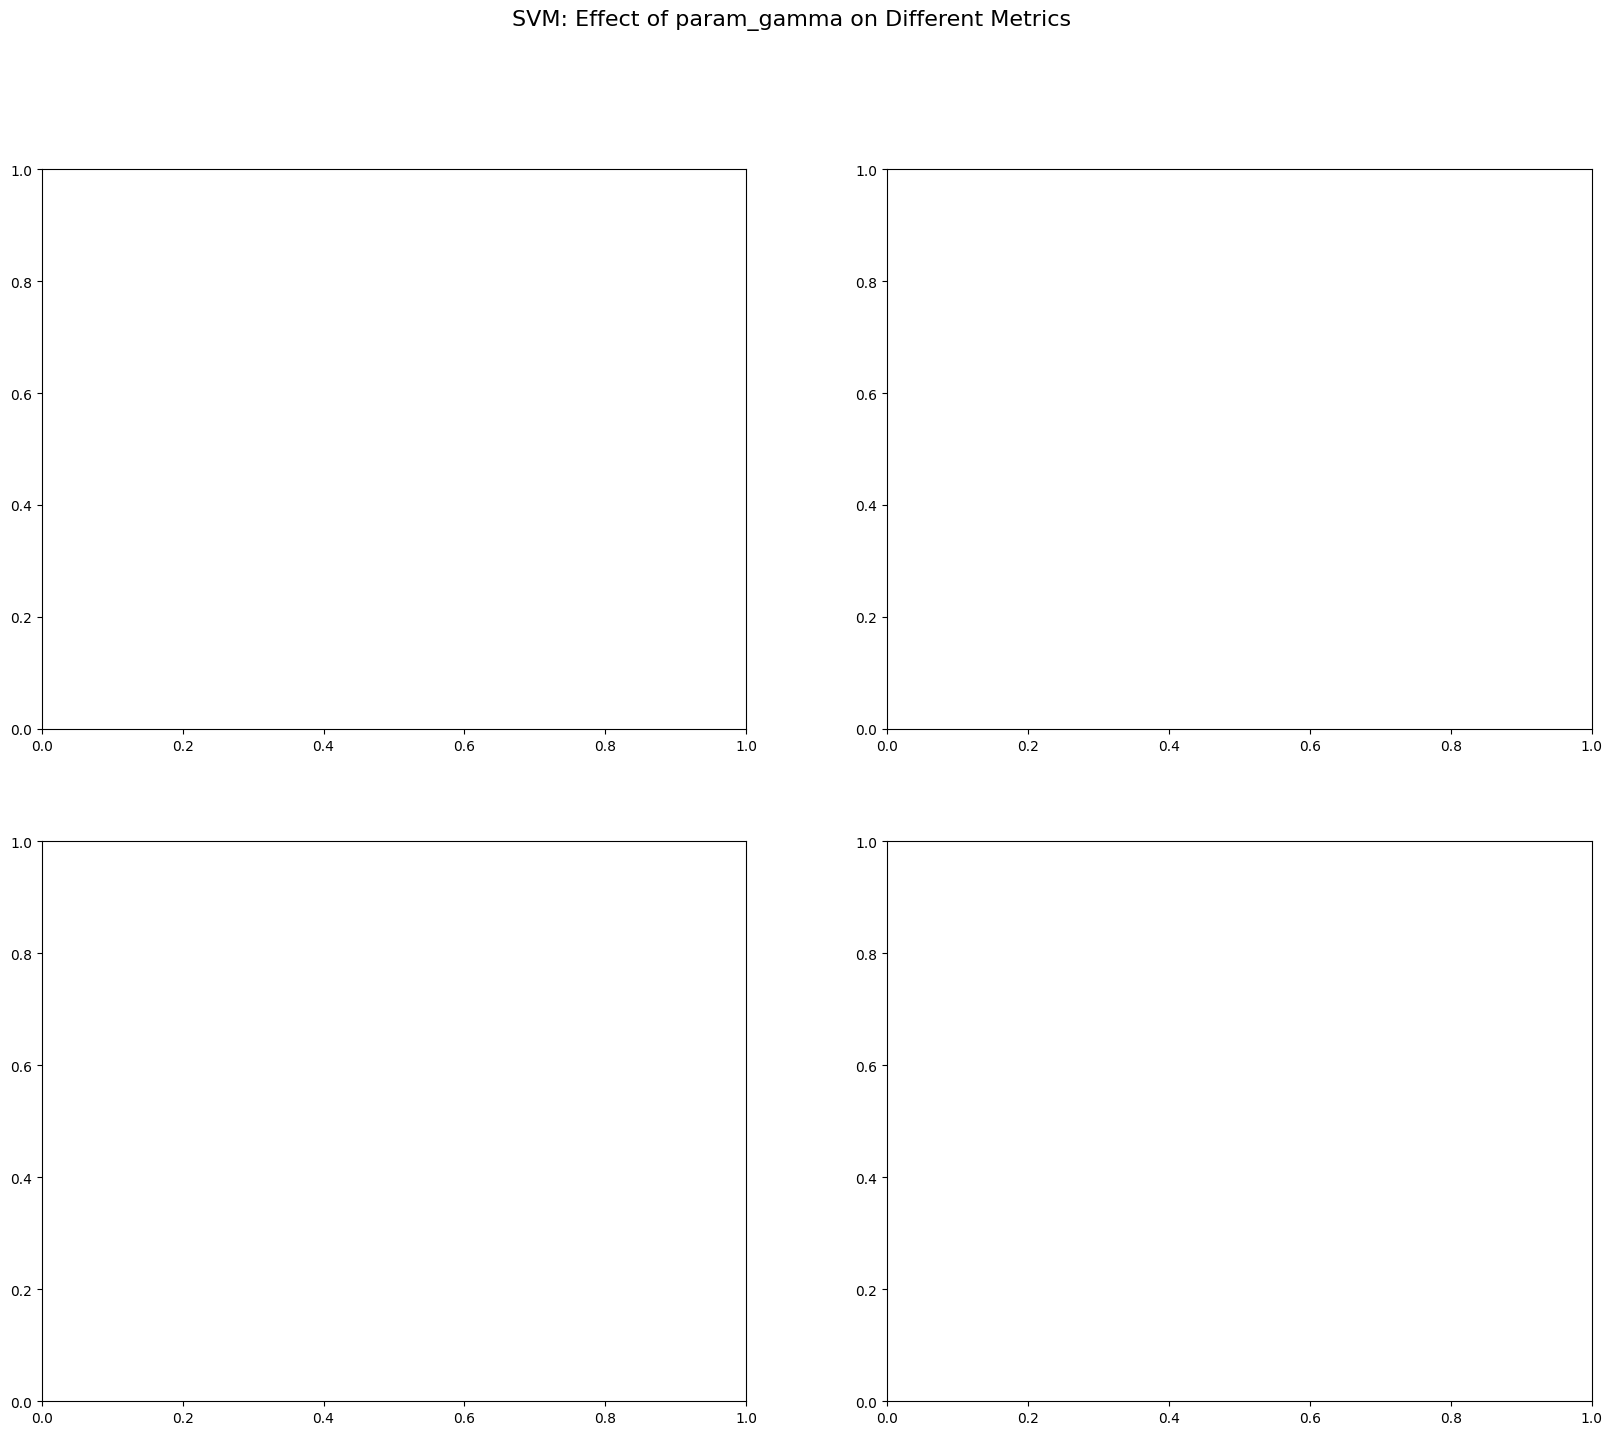

In [16]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any

def plot_hyperparameter_effects(grid_search, classifier_name):
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the hyperparameter names
    param_names = [param for param in results.columns if param.startswith('param_')]
    
    # Create plots for each hyperparameter
    for param in param_names:
        param_name = param.split('__')[-1]  # Extract the actual parameter name
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle(f'{classifier_name}: Effect of {param_name} on Different Metrics', fontsize=16)
        
        metrics = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']
        titles = ['Accuracy', 'Precision', 'Recall', 'F1-score']
        
        for ax, metric, title in zip(axes.ravel(), metrics, titles):
            sns.scatterplot(data=results, x=param, y=metric, ax=ax)
            ax.set_title(f'{title} vs {param_name}')
            ax.set_xlabel(param_name)
            ax.set_ylabel(title)
        
        plt.tight_layout()
        plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)
    plt.title(title)
    plt.show()

def evaluate_model(model: Any, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    y_pred = model.predict(X_test)

    # y_pred_labels = LABEL_ENCODER_GLOBAL.inverse_transform(y_pred)
    # y_test_labels = LABEL_ENCODER_GLOBAL.inverse_transform(y_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    except AttributeError:
        roc_auc = None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_test': y_test
    }

def plot_results(results: Dict[str, Dict[str, float]]):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(results))
    width = 0.2
    for i, metric in enumerate(metrics):
        values = [results[clf][metric] for clf in results]
        ax.bar(x + i*width, values, width, label=metric)
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(results.keys())
    ax.legend(loc='best')
    plt.show()

pipeline = preprocessor
# Assume X_train, X_test, y_train, y_test are already defined
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
# global LABEL_ENCODER_GLOBAL
# LABEL_ENCODER_GLOBAL = label_encoder

classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "kNN": KNeighborsClassifier()
}

param_distributions = {
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto", 0.1, 1]
    },
    "kNN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}
results = {}
for name, clf in classifiers.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        clf,
        param_grid=param_distributions[name],
        cv=cv,
        n_jobs=-1,
        verbose=1,
        scoring=scoring,
        refit='accuracy'
    )
    
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    results[name] = evaluate_model(best_model, X_test_scaled, y_test)
    results[name]['best_params'] = grid_search.best_params_

    # Plot HP effects
    plot_hyperparameter_effects(grid_search, name)

    # Plot confusion matrix
    y_pred = results[name]['y_pred']
    y_test_plot = results[name]['y_test']
    class_names = label_encoder.classes_
    plot_confusion_matrix(y_test_plot, y_pred, class_names, f"Confusion Matrix - {name}")

for name, result in results.items():
    print(f"\n{name}:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1-score: {result['f1']:.4f}")
    if result['roc_auc']:
        print(f"ROC AUC: {result['roc_auc']:.4f}")

best_classifier = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest Classifier: {best_classifier} with accuracy {results[best_classifier]['accuracy']:.4f}")

plot_results(results)

## 8. Results

Summarise your results in tables, figures! <br>
Document your findings, issues in your report <br>
Upload your best results to Kaggle competition (more information below) <br>
You do not need to implement the algorithms, rely on libraries/modules <br>
- Code just for loading data, pre-processing, running configurations, processing/aggregating results, …

### 8.1 Grading key points:
- datasets & classifiers description/choice reasoning, preprocessing
- classification experiments
- analysis of results, summary, interesting findings
- submission package & report(formal requirements, clarity, structure)

Keep in mind that the grading categories are dependent on each other (e.g. if you do not use preprocessing when
needed, your classification and overall analysis will suffer) <br>
Your methodology and reasoning are more important for grading than just achieving the highest e.g. accuracy when
performing classification

### 8.2 Pointers for your project
Apply the knowledge from the lectures <br>
Document the whole process <br>
Carefully design your experiments:
- work out your experiment design together as a group

Important points:
- Explain your choice of datasets, introduce them, their characteristics
- Briefly describe the preprocessing steps and argue why you chose them
    - Evaluate their impact on the results (mainly scaling)
- Explain your choice of classifiers, describe their characteristics
    - there is no need to give lengthy explanation about how a classifier works (do not repeat
what you heard in the lecture)
- Argue on your choice of performance measures
    - Think and find multiple, suitable measures, argue why you chose them (why are
they necessary, what do they measure/tell us about the performance), and if they
are sufficient
- In the report, include a paragraph briefly describing the steps you took to ensure
that the performance of the classifiers can be compared (think if the
comparison makes sense & research what needs to be fulfilled in order to e.g. compare
the performance of multiple classifiers on one dataset, how to compare the impact of
parameter changes etc.)
- Discuss your experimental results, compare them using tables and figures
- Provide an aggregated comparison of your results as well - i.e. a big table of the
best settings and results for all combinations (and a
summary/findings/conclusions!)
    - The idea is to extract knowledge from your results, not just list everything without
explanations